In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

Using TensorFlow backend.


In [42]:
data=pd.read_csv('nexon.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-03-18,605.5,605.5,597.0,599.0,587.589478,2008400
1,2015-03-19,599.0,608.5,592.0,595.0,583.665588,1985400
2,2015-03-20,640.0,643.0,608.5,623.5,611.622681,5194200
3,2015-03-23,625.5,637.5,622.5,628.5,616.527527,2759000
4,2015-03-24,628.0,645.5,626.5,631.0,618.979858,3780600


In [43]:
high_prices=data.High.values
low_prices=data.Low.values
mid_prices=(high_prices+low_prices)/2

In [44]:
seq_len=50                        #50일간의 데이터
sequence_length=seq_len+1         #51일을 예측

result=[]
for index in range(len(mid_prices)-sequence_length):
    result.append(mid_prices[index:index+sequence_length])   #51개씩 묶음 저장

In [45]:
#정규화
normalized_data=[]
for window in result:
    normalized_window=[((float(p)/float(window[0]))-1) for p in window]  #window를 훑으며 -1 정규화
    normalized_data.append(normalized_window)
    
result=np.array(normalized_data)

In [59]:
row = int(round(result.shape[0] * 0.9))   #train 90%, test10%
train = result[:row, :]
np.random.shuffle(train)                  #random으로 해야 익숙한 학습x

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1074, 50, 1), (119, 50, 1))

In [60]:
model=Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))      #output 1개 다음날의 주식예측

model.compile(loss='mse', optimizer='rmsprop')  #손실 mse, 최적화 rmsprop

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.fit(x_train, y_train,                        #train, test 비교
    validation_data=(x_test, y_test),
    batch_size=10,                                 #10개씩 묶어서 학습
    epochs=20)                                     #20번 반복

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1074 samples, validate on 119 samples
Epoch 1/20
1074/1074 [==============================] - 24s 22ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 2/20
1074/1074 [==============================] - 22s 20ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/20
1074/1074 [==============================] - 22s 20ms/step - loss: 0.0012 - val_loss: 9.3297e-04
Epoch 4/20
1074/1074 [==============================] - 21s 19ms/step - loss: 9.8354e-04 - val_loss: 0.0016
Epoch 5/20
1074/1074 [==============================] - 21s 19ms/step - loss: 8.6615e-04 - val_loss: 7.1950e-04
Epoch 6/20
1074/1074 [==============================] - 21s 19ms/step - loss: 7.7072e-04 - val_loss: 4.6675e-04
Epoch 7/20
1074/1074 [==============================] - 21s 19ms/step - loss: 7.1669e-04 - val_loss: 9.0152e-04
Epoch 8/20
1074/1074 [==============================] - 21s 20ms/step - loss: 6.9468e-04 - val_lo

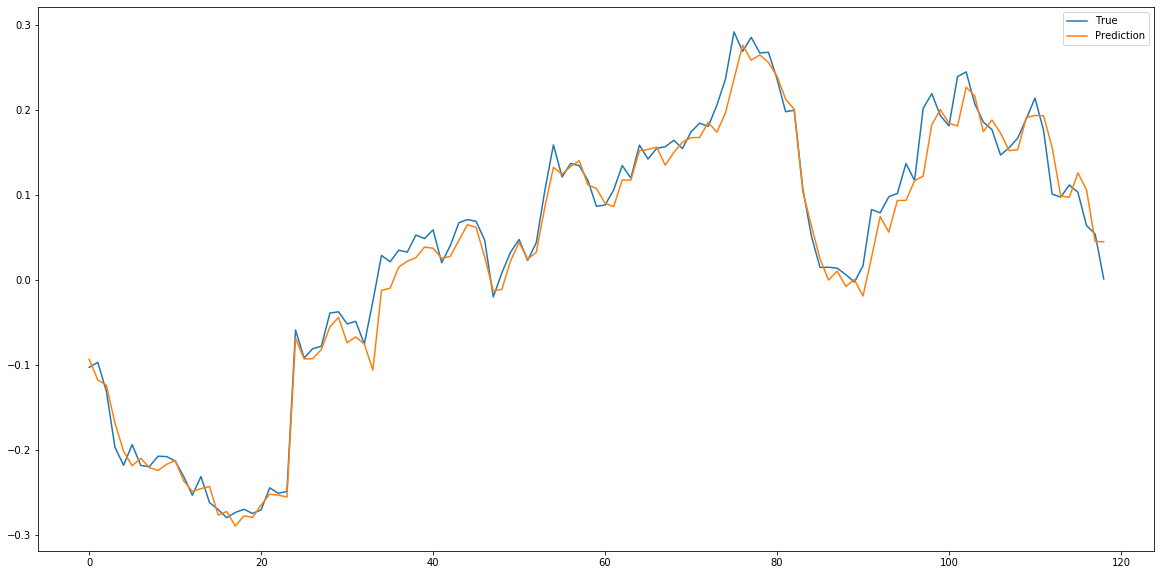

In [62]:
pred = model.predict(x_test)   #test data prediction

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

#prediction 데이터는 50일 주기로 하루예측, 하루예측을 반복하여 그래프로 나타낸숫자이다.